# QNN using PyTorch & Qiskit

In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.primitives import StatevectorEstimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Preparation

In [28]:
X, y = make_moons(n_samples=200, noise=0.15, random_state=42)

scaler = MinMaxScaler(feature_range=(-np.pi/2, np.pi/2))
X = scaler.fit_transform(X)

class MoonDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = MoonDataset(X, y)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

## Building Quantum Circuit

In [ ]:
def create_reuploading_circuit(n_qubits=2, n_layers=3):
    data_params = ParameterVector("x", length=2)
    
    theta_params = ParameterVector("θ", length=n_layers * 2 * n_qubits)

    qc = QuantumCircuit(n_qubits)

    theta_idx = 0
    for layer in range(n_layers):
        for qubit in range(n_qubits):
            qc.rz(data_params[0], qubit)
            qc.rx(data_params[1], qubit)

        for qubit in range(n_qubits):
            qc.ry(theta_params[theta_idx], qubit)
            qc.rz(theta_params[theta_idx+1], qubit)
            theta_idx += 2
        
        for qubit in range(n_qubits-1):
            qc.cx(qubit, qubit+1)

    return qc, data_params, theta_params


## Create EstimatorQNN with TorchConnector

In [ ]:
from qiskit.quantum_info import SparsePauliOp

def build_estimator_qnn(n_qubits=2, n_layers=2):
    qc, data_params, theta_params = create_reuploading_circuit(n_qubits, n_layers)
    
    pauli_string = "Z" + "I"*(n_qubits - 1)
    observable = [SparsePauliOp.from_list([(pauli_string, 1.0)])]
    
    estimator = StatevectorEstimator()
    qnn = EstimatorQNN(
        circuit=qc,
        observables=observable,
        input_params=list(data_params),
        weight_params=list(theta_params),
        estimator=estimator,
    )
    return qnn


## Define Hybrid Module

In [ ]:
class HybridModel(nn.Module):
    def __init__(self, n_qubits=2, n_layers=2):
        super().__init__()
        
        self.qnn = build_estimator_qnn(n_qubits=n_qubits, n_layers=n_layers)
        
        self.qnn_torch = TorchConnector(self.qnn)
        
        self.classifier = nn.Sequential(
            nn.Linear(1, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        q_output = self.qnn_torch(x)
        
        out = self.classifier(q_output)
        return out.squeeze()

## Train Model

In [38]:
def train_model(model, data_loader, epochs=100, lr=0.01):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_x, batch_y in data_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = F.binary_cross_entropy(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(data_loader)
        losses.append(epoch_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

    return losses

In [39]:
model = HybridModel(n_qubits=2, n_layers=3).to(device)

losses = train_model(model, train_loader, epochs=150, lr=0.01)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Epoch [10/150], Loss: 0.3920
Epoch [20/150], Loss: 0.1333
Epoch [30/150], Loss: 0.0822
Epoch [40/150], Loss: 0.0579
Epoch [50/150], Loss: 0.0667
Epoch [60/150], Loss: 0.0408
Epoch [70/150], Loss: 0.0384
Epoch [80/150], Loss: 0.0329
Epoch [90/150], Loss: 0.0316
Epoch [100/150], Loss: 0.0332
Epoch [110/150], Loss: 0.0301
Epoch [120/150], Loss: 0.0290
Epoch [130/150], Loss: 0.0287
Epoch [140/150], Loss: 0.0286
Epoch [150/150], Loss: 0.0283


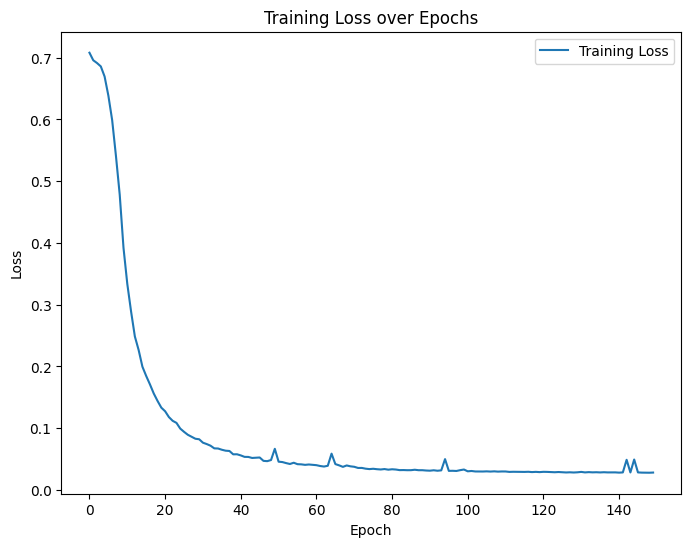

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.show()

## Show Decision Boundary

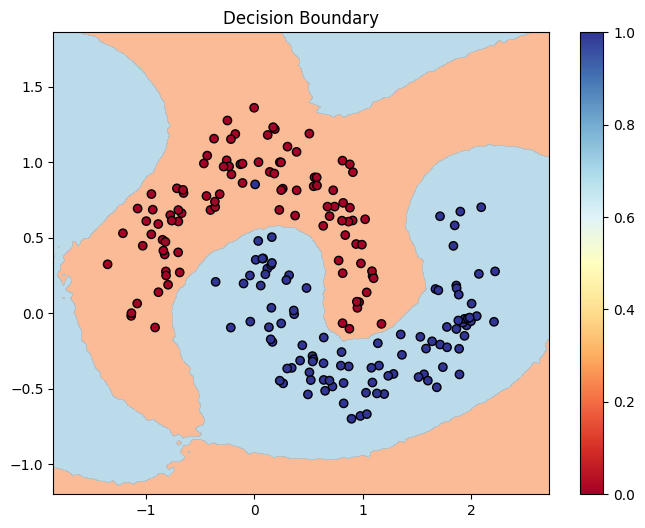

In [ ]:
def plot_decision_boundary(model, X, y):
    model.eval()

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 100),
        np.linspace(y_min, y_max, 100)
    )
    grid = np.column_stack([xx.ravel(), yy.ravel()])

    grid_torch = torch.tensor(scaler.transform(grid), dtype=torch.float32).to(device)
    with torch.no_grad():
        preds = model(grid_torch).cpu().numpy().reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, preds, levels=[0, 0.5, 1], cmap=plt.cm.RdYlBu, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolor='k')
    plt.title("Decision Boundary")
    plt.colorbar()
    plt.show()

plot_decision_boundary(model, scaler.inverse_transform(X), y)